In [1]:
import uuid, sys, os
import pandas as pd
pd.set_option("display.max_columns", None)   # show all columns
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### Loading and wrangling dataset

In [2]:
boltzgen_df = pd.read_csv("/work3/s232958/data/boltzgen/boltzgen.csv")
boltzgen_df = boltzgen_df[(boltzgen_df["A_seq"].notna())& (boltzgen_df["target_subchain_B_seq"].notna())].reset_index(drop=True)
boltzgen_df = boltzgen_df[boltzgen_df["target_chains"] == "[\"B\"]"]
boltzgen_df = boltzgen_df[boltzgen_df["target_subchain_B_seq"].notna()].reset_index(drop=True)

cols_remain = ["binder_id", "A_seq", "target_id", "target_subchain_B_seq", "binder_type", "binding", "boltz_iptm_avg", "af3_iptm_model_0"]

boltzgen_df_filtered = boltzgen_df[cols_remain].rename(columns = {
    "A_seq" : "binder_seq",
    "target_subchain_B_seq" : "target_seq",
    "boltz_iptm_avg" : "boltz_iptm",
    "af3_iptm_model_0" : "af3_iptm",
    "binding" : "binder"
})

boltzgen_df_filtered

,binder_id,binder_seq,target_id,target_seq,binder_type,binder,boltz_iptm,af3_iptm
0,pdgfrprot_16471,SHFVIGTAEAKSDSDEDIREALEKAANEAAEKAGLPPVKLTSVEIK...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,False,0.937140,0.88
1,insulinprot_34946,NPVVEEARKLLEKAKELLDEARKLLEEGDYEKAKELIEEAEKLLKE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,prot,False,0.170498,0.45
2,pdgfrprot_35947,ITEEQRKELIEKAAELVVKAIEEGKLASEVKKELKEFAKKLGVELT...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,True,0.945968,0.79
3,insulinnano_52317,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNYAMGWFRQAPGKGRE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,nano,False,0.200709,0.14
4,1g13prot_19735,GKLSGKQLLELFKEKVKKLLEGKEELTREEVLEIVEKAVEETVKEA...,1g13,SSFSWDNCDEGKDPAVIRSLTLEPDPIIVPGNVTLSVMGSTSVPLS...,prot,False,0.851551,0.83
...,...,...,...,...,...,...,...,...
417,3qkgprot_47078,AVYTAVLTNTETGKEFTGTGKTPEEALRNAAEKFGREEGLGLEEVI...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.600571,0.85
418,3qkgprot_02705,ATEKVTVTCPLTGKEITVEIPVPPTVESLADAVVEIAKKCGLYATH...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,True,0.871538,0.74
419,3qkgprot_42882,APMTFKITLKNVETGVVEEVTVTAESAKAALEEALVKFNIDPFSIA...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.894542,0.78
420,3qkgprot_39630,AKRAIELAKAGRLEEAVEAVVEAAREKGLSDEEADLVRQGLVYAVE...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.870742,0.88


In [3]:
# quick check whether each target has a single chain
assert len(boltzgen_df_filtered.target_id.unique()) == len(boltzgen_df_filtered.target_seq.unique())

In [4]:
boltzgen_df_filtered.target_id.unique()

array(['pdgfr', 'insulin', '1g13', 'tnfalpha', '3apu', '7aah', 'il7ra',
       '2pny', '1jqd', 'pdl1', '3ch4', '2a1x', '1nb0', '3qkg'],
      dtype=object)

In [5]:
targets_counter = {}
for target in boltzgen_df_filtered.target_id.unique():
    targets_counter[target] = 1

binder_id2 = []
for __, row in boltzgen_df_filtered.iterrows():
    key = row.target_id
    _id = f"{key}_{targets_counter[key]}"
    binder_id2.append(_id)
    targets_counter[key] = targets_counter[key]+1
    
boltzgen_df_filtered["binder_id2"] = binder_id2
boltzgen_df_filtered["len_binder_seq"] = [len(seq) for seq in boltzgen_df_filtered["binder_seq"]]
boltzgen_df_filtered["len_target_seq"] = [len(seq) for seq in boltzgen_df_filtered["target_seq"]]
boltzgen_df_filtered

,binder_id,binder_seq,target_id,target_seq,binder_type,binder,boltz_iptm,af3_iptm,binder_id2,len_binder_seq,len_target_seq
0,pdgfrprot_16471,SHFVIGTAEAKSDSDEDIREALEKAANEAAEKAGLPPVKLTSVEIK...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,False,0.937140,0.88,pdgfr_1,89,289
1,insulinprot_34946,NPVVEEARKLLEKAKELLDEARKLLEEGDYEKAKELIEEAEKLLKE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,prot,False,0.170498,0.45,insulin_1,85,894
2,pdgfrprot_35947,ITEEQRKELIEKAAELVVKAIEEGKLASEVKKELKEFAKKLGVELT...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,True,0.945968,0.79,pdgfr_2,81,289
3,insulinnano_52317,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNYAMGWFRQAPGKGRE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,nano,False,0.200709,0.14,insulin_2,132,894
4,1g13prot_19735,GKLSGKQLLELFKEKVKKLLEGKEELTREEVLEIVEKAVEETVKEA...,1g13,SSFSWDNCDEGKDPAVIRSLTLEPDPIIVPGNVTLSVMGSTSVPLS...,prot,False,0.851551,0.83,1g13_1,112,162
...,...,...,...,...,...,...,...,...,...,...,...
417,3qkgprot_47078,AVYTAVLTNTETGKEFTGTGKTPEEALRNAAEKFGREEGLGLEEVI...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.600571,0.85,3qkg_26,86,193
418,3qkgprot_02705,ATEKVTVTCPLTGKEITVEIPVPPTVESLADAVVEIAKKCGLYATH...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,True,0.871538,0.74,3qkg_27,84,193
419,3qkgprot_42882,APMTFKITLKNVETGVVEEVTVTAESAKAALEEALVKFNIDPFSIA...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.894542,0.78,3qkg_28,92,193
420,3qkgprot_39630,AKRAIELAKAGRLEEAVEAVVEAAREKGLSDEEADLVRQGLVYAVE...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.870742,0.88,3qkg_29,82,193


In [6]:
targets_binders_Dict = {}
for __, row in boltzgen_df_filtered.iterrows():
    tkey = row.target_id
    tseq = row.target_seq
    bkey = row.binder_id2
    bseq = row.binder_seq
    if tkey not in targets_binders_Dict.keys():
        targets_binders_Dict[tkey] = tseq
    if bseq not in targets_binders_Dict.values():
        targets_binders_Dict[bkey] = bseq
    else:
        msg = f"Duplicate binder found: {bkey}, {bseq}"
        print(msg, file=sys.stderr)
        raise RuntimeError(msg)

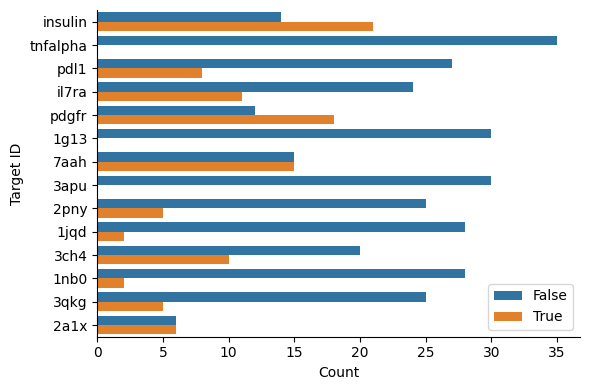

In [7]:
boltzgen_df_filtered.target_id.value_counts()

order = boltzgen_df_filtered['target_id'].value_counts().index

plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=boltzgen_df_filtered,
    y='target_id',
    order=order,
    hue = "binder"
)
ax.set_xlabel('Count')
ax.set_ylabel('Target ID')
ax.legend(loc='lower right')  
sns.despine()
plt.tight_layout()
plt.show()

In [8]:
boltzgen_df_filtered.binder.value_counts()

binder
False    319
True     103
Name: count, dtype: int64

In [9]:
len(targets_binders_Dict)

436

In [10]:
boltzgen_df_filtered.to_csv("/work3/s232958/data/boltzgen/boltzgen_df_filtered.csv", index = False)

### Validate PPint pre-trained model using boltzgen embeddings

In [11]:
def create_key_padding_mask(embeddings, padding_value=0, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input,padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input,padding_value=self.padding_value)
 
        # Initialize residual states
        # pep_emb = pep_input.clone()
        # prot_emb = prot_input.clone()

        pep_emb  = pep_input
        prot_emb = prot_input
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) # Dot-Product for comparison
        
        return logits
    

    def training_step(self, batch, device):
        # Passing the sequences to the models
 
        embedding_pep = batch[0]
        embedding_prot = batch[1]
 
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        positive_logits = self(embedding_pep, embedding_prot)
        
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)

        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep = batch[0]
        embedding_prot = batch[1]
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        with torch.no_grad():

            positive_logits = self(
                    embedding_pep,
                    embedding_prot,
                    # interaction_pep,
                    # interaction_prot,
                    # int_prob = 0.0
                    )
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1) 
            

            negative_logits = self(embedding_pep[rows,:,:], 
                              embedding_prot[cols,:,:], 
                              int_prob=0.0)
                   
            
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
            # partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        positive_logits = self(
            embedding_pep,
            embedding_prot)
        
        # Negaive indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) 
        
        negative_logits = self(embedding_pep[rows,:,:], 
                      embedding_prot[cols,:,:], 
                      int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        # Fill diagonal with positive scores
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        return logit_matrix

In [12]:
path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # or model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [13]:
class CLIP_boltzgen_dataset(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1152,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.encoding_path = path

        # lengths
        self.max_blen = self.dframe["len_binder_seq"].max()
        self.max_tlen = self.dframe["len_target_seq"].max()

        # index & storage
        self.dframe.set_index("binder_id2", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESMC embeddings"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = parts[0]
            bnd_id = accession
            # lbl = torch.tensor(int(self.dframe.loc[accession, "binder"]))

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb, t_emb = self.samples[idx]
        b_emb, t_emb = torch.from_numpy(b_emb).float(), torch.from_numpy(t_emb).float()
        return b_emb, t_emb

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        return b, t

Boltzgen_dataset = CLIP_boltzgen_dataset(boltzgen_df_filtered, path = "/work3/s232958/data/boltzgen/embeddings_esmC", embedding_dim=1152)

#Loading ESMC embeddings: 100%|██████████████████████████████████████████████████████| 422/422 [00:02<00:00, 163.79it/s]


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Boltzgen_loader = DataLoader(Boltzgen_dataset, batch_size=20, shuffle=False)

@torch.no_grad()
def run_batch(model, batch, device):
    binders_batch, targets_batch = batch      # unpack
    binders_batch = binders_batch.to(device)
    targets_batch = targets_batch.to(device)
    logits = model(binders_batch, targets_batch)
    return logits

model.to(device)
model.eval()

interaction_scores = []

for batch in tqdm(Boltzgen_loader, desc="#Iterating through batched data"):
    logits = run_batch(model, batch, device)
    interaction_scores.append(logits.cpu())

interaction_scores = torch.cat(interaction_scores, dim=0)
interaction_probabilities = [torch.sigmoid(int_score).cpu().numpy() for int_score in interaction_scores]

boltzgen_df_filtered["inter_prob"] = interaction_probabilities
boltzgen_df_filtered["pred_binder"] = boltzgen_df_filtered["inter_prob"] >= 0.5
boltzgen_df_filtered["intr_scores"] = interaction_scores

boltzgen_df_filtered

#Iterating through batched data: 100%|██████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.09it/s]


,binder_id,binder_seq,target_id,target_seq,binder_type,binder,boltz_iptm,af3_iptm,binder_id2,len_binder_seq,len_target_seq,inter_prob,pred_binder,intr_scores
0,pdgfrprot_16471,SHFVIGTAEAKSDSDEDIREALEKAANEAAEKAGLPPVKLTSVEIK...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,False,0.937140,0.88,pdgfr_1,89,289,0.972011,True,3.547557
1,insulinprot_34946,NPVVEEARKLLEKAKELLDEARKLLEEGDYEKAKELIEEAEKLLKE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,prot,False,0.170498,0.45,insulin_1,85,894,0.7931803,True,1.344203
2,pdgfrprot_35947,ITEEQRKELIEKAAELVVKAIEEGKLASEVKKELKEFAKKLGVELT...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,True,0.945968,0.79,pdgfr_2,81,289,0.84521854,True,1.697581
3,insulinnano_52317,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNYAMGWFRQAPGKGRE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,nano,False,0.200709,0.14,insulin_2,132,894,0.7689139,True,1.202189
4,1g13prot_19735,GKLSGKQLLELFKEKVKKLLEGKEELTREEVLEIVEKAVEETVKEA...,1g13,SSFSWDNCDEGKDPAVIRSLTLEPDPIIVPGNVTLSVMGSTSVPLS...,prot,False,0.851551,0.83,1g13_1,112,162,0.5789786,True,0.318582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,3qkgprot_47078,AVYTAVLTNTETGKEFTGTGKTPEEALRNAAEKFGREEGLGLEEVI...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.600571,0.85,3qkg_26,86,193,0.5160542,True,0.064239
418,3qkgprot_02705,ATEKVTVTCPLTGKEITVEIPVPPTVESLADAVVEIAKKCGLYATH...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,True,0.871538,0.74,3qkg_27,84,193,0.0916712,False,-2.293398
419,3qkgprot_42882,APMTFKITLKNVETGVVEEVTVTAESAKAALEEALVKFNIDPFSIA...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.894542,0.78,3qkg_28,92,193,0.796863,True,1.366802
420,3qkgprot_39630,AKRAIELAKAGRLEEAVEAVVEAAREKGLSDEEADLVRQGLVYAVE...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.870742,0.88,3qkg_29,82,193,0.41864786,False,-0.328327


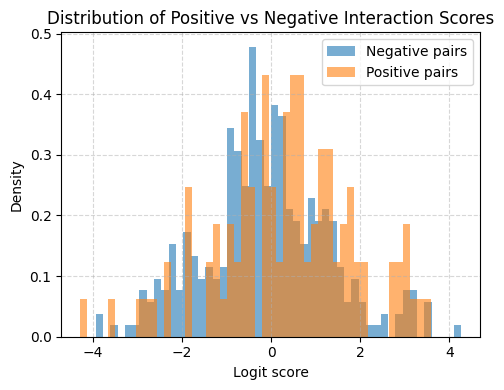

In [15]:
pos_logits, neg_logits = [], []
for __, row in boltzgen_df_filtered.iterrows():
    logit = row.intr_scores
    if row.binder == False:
        # neg_logits.append(np.tanh(logit))
        neg_logits.append(logit)
    elif row.binder == True:
        # pos_logits.append(np.tanh(logit))
        pos_logits.append(logit)

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))

plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
labels = torch.as_tensor(boltzgen_df_filtered["binder"].to_numpy(copy=False), dtype=torch.float32, device=device)
logits = torch.as_tensor(interaction_scores, dtype=torch.float32, device=device)

loss = F.binary_cross_entropy_with_logits(logits, labels)
loss

tensor(0.8263, device='cuda:0')

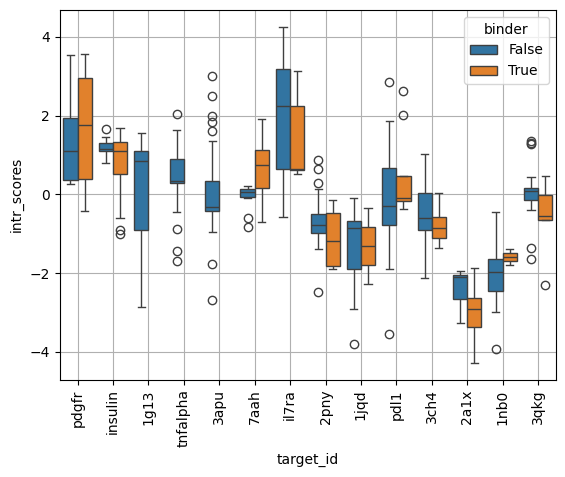

In [17]:
sns.boxplot(data=boltzgen_df_filtered,x="target_id",y="intr_scores",hue="binder",legend=True)
plt.xticks(rotation=90)
plt.grid()
plt.show()

              precision    recall  f1-score   support

       False     0.8084    0.5423    0.6492       319
        True     0.2981    0.6019    0.3987       103

    accuracy                         0.5569       422
   macro avg     0.5532    0.5721    0.5239       422
weighted avg     0.6839    0.5569    0.5880       422

AUC: 0.600


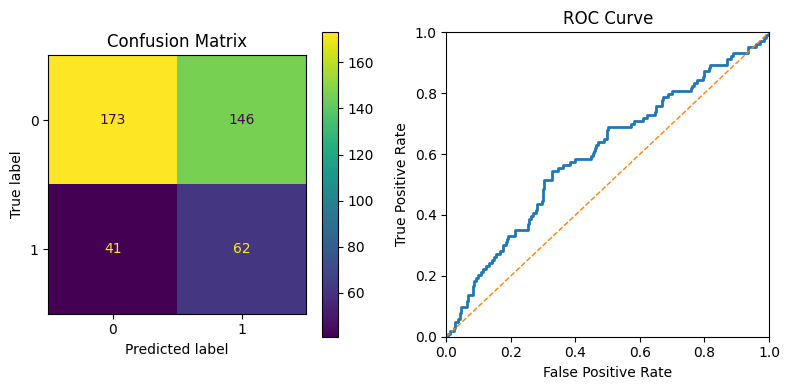

In [18]:
pred_labels = np.array(boltzgen_df_filtered.pred_binder)
true_labels = np.array(boltzgen_df_filtered["binder"])

true_positives = ((pred_labels == 1) & (true_labels == 1)).sum().item()
true_negatives = ((pred_labels == 0) & (true_labels == 0)).sum().item()
false_positives = ((pred_labels == 1) & (true_labels == 0)).sum().item()
false_negatives = ((pred_labels == 0) & (true_labels == 1)).sum().item()

predicted_positives = true_positives + false_positives
all_real_positives = true_positives + false_negatives

print(metrics.classification_report(true_labels, pred_labels, digits = 4))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix")

TPR = true_positives / (true_positives + true_negatives) # how good the model is at predicting the positive class when the actual outcome is positive.
# sensitivity = true_positives / (true_positives + false_negatives) # the same as TPR
FPR = false_positives / (false_positives + true_negatives) # how often a positive class is predicted when the actual outcome is negative.
# specificity = true_negatives / (true_negatives + false_positives) # FPR = 1 - specificity

fpr, tpr, thresholds = metrics.roc_curve(true_labels, interaction_scores)
auc = metrics.roc_auc_score(true_labels, interaction_scores)
print('AUC: %.3f' % auc)

axes[1].plot(fpr, tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal reference
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve')

# show the plot
plt.tight_layout()
plt.show()

In [19]:
boltzgen_df_filtered

,binder_id,binder_seq,target_id,target_seq,binder_type,binder,boltz_iptm,af3_iptm,binder_id2,len_binder_seq,len_target_seq,inter_prob,pred_binder,intr_scores
0,pdgfrprot_16471,SHFVIGTAEAKSDSDEDIREALEKAANEAAEKAGLPPVKLTSVEIK...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,False,0.937140,0.88,pdgfr_1,89,289,0.972011,True,3.547557
1,insulinprot_34946,NPVVEEARKLLEKAKELLDEARKLLEEGDYEKAKELIEEAEKLLKE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,prot,False,0.170498,0.45,insulin_1,85,894,0.7931803,True,1.344203
2,pdgfrprot_35947,ITEEQRKELIEKAAELVVKAIEEGKLASEVKKELKEFAKKLGVELT...,pdgfr,LVVTPPGPELVLNVSSTFVLTCSGSAPVVWERMSQEPPQEMAKAQD...,prot,True,0.945968,0.79,pdgfr_2,81,289,0.84521854,True,1.697581
3,insulinnano_52317,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNYAMGWFRQAPGKGRE...,insulin,HLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDF...,nano,False,0.200709,0.14,insulin_2,132,894,0.7689139,True,1.202189
4,1g13prot_19735,GKLSGKQLLELFKEKVKKLLEGKEELTREEVLEIVEKAVEETVKEA...,1g13,SSFSWDNCDEGKDPAVIRSLTLEPDPIIVPGNVTLSVMGSTSVPLS...,prot,False,0.851551,0.83,1g13_1,112,162,0.5789786,True,0.318582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,3qkgprot_47078,AVYTAVLTNTETGKEFTGTGKTPEEALRNAAEKFGREEGLGLEEVI...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.600571,0.85,3qkg_26,86,193,0.5160542,True,0.064239
418,3qkgprot_02705,ATEKVTVTCPLTGKEITVEIPVPPTVESLADAVVEIAKKCGLYATH...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,True,0.871538,0.74,3qkg_27,84,193,0.0916712,False,-2.293398
419,3qkgprot_42882,APMTFKITLKNVETGVVEEVTVTAESAKAALEEALVKFNIDPFSIA...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.894542,0.78,3qkg_28,92,193,0.796863,True,1.366802
420,3qkgprot_39630,AKRAIELAKAGRLEEAVEAVVEAAREKGLSDEEADLVRQGLVYAVE...,3qkg,GPVPTPPDNIQVQENFNISRIYGKWYNLAIGSTSPWLKKIMDRMTV...,prot,False,0.870742,0.88,3qkg_29,82,193,0.41864786,False,-0.328327


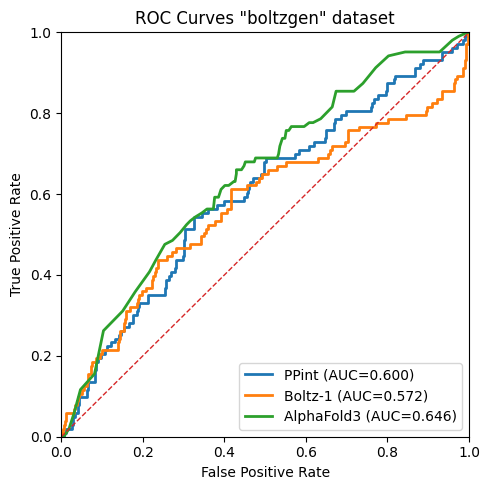

In [20]:
scores = {
    "PPint": np.asarray(boltzgen_df_filtered["intr_scores"]),
    "Boltz-1": np.asarray(boltzgen_df_filtered["boltz_iptm"]),
    "AlphaFold3": np.asarray(boltzgen_df_filtered["af3_iptm"]),
}

plt.figure(figsize=(5,5))
for model, values in scores.items():
    fpr, tpr, _ = metrics.roc_curve(true_labels, values)
    auc = metrics.roc_auc_score(true_labels, values)
    plt.plot(fpr, tpr, linewidth=2, label=f"{model} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", linewidth=1)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curves "boltzgen" dataset')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Average precission of PPint model:0.3194
Average precission of AF3 model:0.3505
Average precission of Boltz model:0.3395
Average precision (AP):
  PPint: 0.3194
  AlphaFold3: 0.3505
  Boltz-1: 0.3395


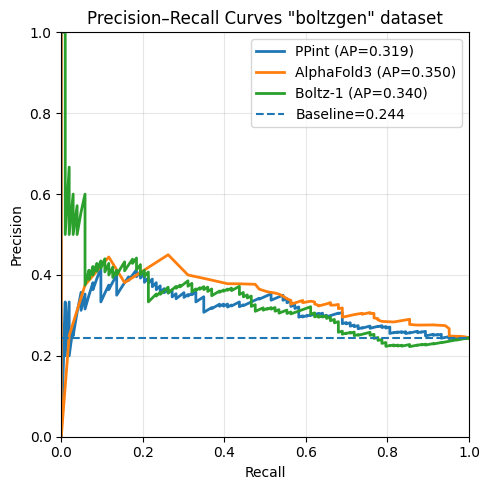

In [21]:
true_labels
pred_PPint = np.asarray(boltzgen_df_filtered.intr_scores)
pred_boltz = np.asarray(boltzgen_df_filtered.boltz_iptm)
pred_af3 = np.asarray(boltzgen_df_filtered.af3_iptm)

AP_PPint = average_precision_score(true_labels, pred_PPint)
AP_af3 = average_precision_score(true_labels, pred_af3)
AP_boltz = average_precision_score(true_labels, pred_boltz)

print(f"Average precission of PPint model:{AP_PPint:.4f}")
print(f"Average precission of AF3 model:{AP_af3:.4f}")
print(f"Average precission of Boltz model:{AP_boltz:.4f}")

models = {
    "PPint": pred_PPint,
    "AlphaFold3":   pred_af3,
    "Boltz-1": pred_boltz,
}

# Compute and print APs
print("Average precision (AP):")
ap_values = {}
for name, scores in models.items():
    ap = average_precision_score(true_labels, scores)
    ap_values[name] = ap
    print(f"  {name}: {ap:.4f}")

# Plot PR curves
plt.figure(figsize=(5,5))

for name, scores in models.items():
    precision, recall, _ = precision_recall_curve(true_labels, scores)
    ap = ap_values[name]
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", linewidth=2)

# Baseline = positive class prevalence
pos_rate = true_labels.mean()
plt.hlines(pos_rate, 0, 1, linestyles="dashed", label=f"Baseline={pos_rate:.3f}")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision–Recall Curves "boltzgen" dataset')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
boltzgen_df_filtered.to_csv("boltzgen_scores.csv", index=False)